In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spotify-app-reviews-2022/reviews.csv
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin.gz
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


In [2]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import spacy
import random
import collections
import re
import emoji

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gensim

In [3]:
%%time

# Path to dataset
word2vec_path = "/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"

# Load 200,000 most common words
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=200000) 

CPU times: user 1.68 s, sys: 466 ms, total: 2.15 s
Wall time: 3.34 s


In [4]:
# Get word vector
science = word2vec_model['science']

# Print shape and vector
print('Vector dimension:', science.shape)
print(science)

Vector dimension: (300,)
[ 0.0090332   0.12158203  0.3984375   0.21386719 -0.01672363  0.06396484
  0.3125     -0.23535156 -0.10009766 -0.09326172  0.20507812 -0.03222656
 -0.21191406  0.00958252 -0.27734375  0.09619141 -0.1875     -0.04052734
  0.2265625  -0.23632812 -0.04858398  0.03295898 -0.08056641  0.12255859
  0.05859375 -0.09130859 -0.02685547  0.02587891 -0.11376953 -0.21972656
 -0.0378418  -0.15722656 -0.05981445 -0.01635742  0.11425781 -0.15234375
 -0.01086426  0.29296875  0.22265625 -0.00245667 -0.16308594 -0.11669922
 -0.20800781  0.31835938 -0.08740234  0.13378906  0.15429688  0.11816406
 -0.07470703  0.09326172 -0.32421875  0.01239014 -0.07226562 -0.10986328
 -0.07177734  0.16113281  0.05541992 -0.3984375  -0.04980469 -0.25195312
 -0.05249023 -0.05786133  0.16699219 -0.26953125 -0.04394531 -0.14257812
  0.03662109  0.34765625 -0.10888672 -0.12011719 -0.19335938 -0.21972656
  0.16015625 -0.06542969 -0.22070312  0.1484375   0.23144531  0.11669922
 -0.15429688  0.04174805 -

In [5]:
print(word2vec_model.similarity('science', 'mathematics'))
print(word2vec_model.similarity('science', 'space'))
print(word2vec_model.similarity('science', 'beard'))

0.630091
0.23719835
0.0036594481


In [6]:
word2vec_model.n_similarity("Man goes running".split(),"Woman goes swimming".split())

0.6724018

In [7]:
word2vec_model.most_similar(positive=['jelly'], topn=10)

[('custard', 0.5662760734558105),
 ('Jell_O', 0.5641272068023682),
 ('chocolate_pudding', 0.5506998300552368),
 ('marshmallow', 0.546853244304657),
 ('marmalade', 0.5442028641700745),
 ('jellies', 0.5395851731300354),
 ('Jello', 0.5389018654823303),
 ('gummy', 0.5371953248977661),
 ('gelatinous', 0.5302338004112244),
 ('mousse', 0.5300459861755371)]

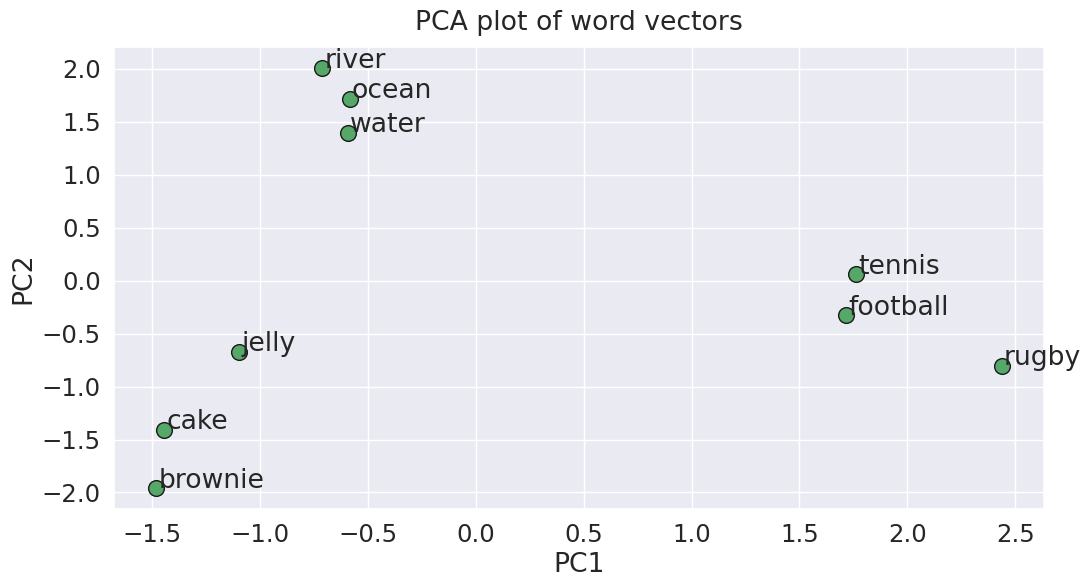

In [8]:
# Vectors to transform
words = ["football","tennis","rugby","river","ocean","water","brownie","jelly","cake"] #['swim', 'swimming', 'cat', 'dog', 'feline', 'road', 'car', 'bus']
word_vectors = np.array([word2vec_model[w] for w in words])

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(word_vectors)

# Plot transformed vectors
plt.figure(figsize=(12,6))
plt.scatter(X_pca[:,0], X_pca[:,1], edgecolors='k', c='g', s=128)
for word, (x,y) in zip(words, X_pca):
    plt.text(x+0.01,y+0.01, word)
plt.title("PCA plot of word vectors", y=1.02)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [9]:
word2vec_model.most_similar(positive=["France", "Tokyo"], negative=["Paris"], topn=3)

[('Japan', 0.8167770504951477),
 ('Japanese', 0.6480902433395386),
 ('South_Korea', 0.6141558885574341)]

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">Modelling with pre-trained word embeddings</p>

To showcase how word embeddings can be used in neural networks, we are going to perform sentiment analysis on a **spotify app reviews dataset**. Each review has a corresponding number of **stars** awarded **between 1 and 5**, which is what we are going to try to predict.

In [10]:
# Load data
data = pd.read_csv("/kaggle/input/spotify-app-reviews-2022/reviews.csv")
data = data[["Review","Rating"]]

# Print shape and preview
print(data.shape)
data.head()

(61594, 2)


,Review,Rating
0,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",5
1,Please ignore previous negative rating. This app is super great. I give it five stars+,5
2,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,1


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


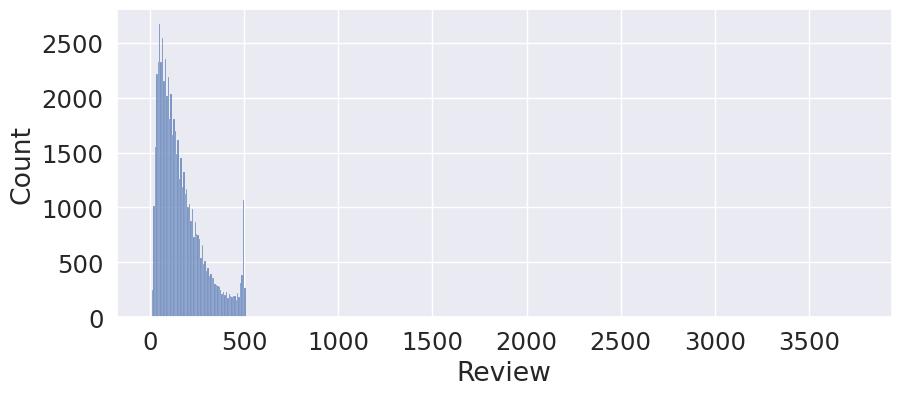

In [11]:
# Lenght of reviews
plt.figure(figsize=(10,4))
sns.histplot(data["Review"].apply(lambda x : len(x)))
plt.show()

In [12]:
# Clean text function
def clean_text(text):
    text = emoji.demojize(text)                # Remove emojis
    text = text.replace('_', ' ')              # Replace underscores with space
    text = text.strip()                        # Remove extra spaces
    return text

# Applying cleaning function
data["Review"] = data["Review"].apply(lambda x: clean_text(x))

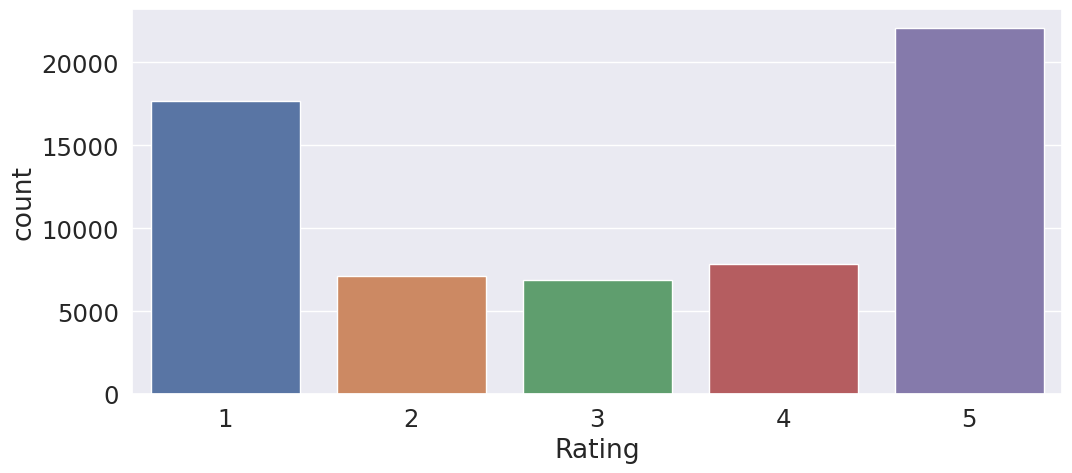

In [13]:
# Lenght of reviews
plt.figure(figsize=(12,5))
sns.countplot(data=data, x="Rating")
plt.show()

**Features and labels**

In [14]:
# Define features and labels
X = data["Review"]
y = data["Rating"] - 1         # map to 0,1,2,3,4

**Train-valid-test split**

In [15]:
# Create train, validation and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_tr, y_tr, test_size=0.25, shuffle=True, stratify=y_tr, random_state=0) # 0.25 * 0.8 = 0.2

# Print shapes
print("Train size:", X_train.shape)
print("Valid size:", X_valid.shape)
print("Test size:", X_test.shape)

Train size: (36956,)
Valid size: (12319,)
Test size: (12319,)


**Tokenizer**rr

In [16]:
# Keras tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words=20000, filters='0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

# Build vocabulary on train set
tokenizer.fit_on_texts(X_train)

**Vectorize**

We are going to vectorize by mapping every token to an **integer ID** that we can use to look up word vectors.

In [17]:
# Vectorize
X_train_ids = tokenizer.texts_to_sequences(X_train)
X_valid_ids = tokenizer.texts_to_sequences(X_valid)
X_test_ids = tokenizer.texts_to_sequences(X_test)

# Example
print(X_train_ids[0][:10])

[1, 116, 8, 29, 28, 944, 25, 10, 211, 22]


In [18]:
# Max length of sequences
max_length = 250

# Pad sequences
X_train_pad = keras.preprocessing.sequence.pad_sequences(X_train_ids, maxlen=max_length)
X_valid_pad = keras.preprocessing.sequence.pad_sequences(X_valid_ids, maxlen=max_length)
X_test_pad = keras.preprocessing.sequence.pad_sequences(X_test_ids, maxlen=max_length)

# Example
print(X_train_pad[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   1 116   8  29  28 944  25
  10 211  22   5 265  74 187  22   8  27 108  89  28 944 226   5   5  98
 273 187  22  45 944 294  30  80  39 205  40  75   

**Lookup dictionary**

<br>

We now to **map** the word ids to the word vectors in gensim so we can use them in our model. We do this by creating an **embedding matrix** that stores the word vectors in the right order if they exist (otherwise fill that row with 0's).

In [19]:
# Load 1,000,000 most common words
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1_000_000)

# Add one for padding token
num_tokens = len(tokenizer.word_index) + 1

# Word vector dimension
embedding_dim = 300

# Initialize matrix of zeros
embedding_matrix = np.zeros((num_tokens, embedding_dim))

# Fill embedding matrix
for word, i in tokenizer.word_index.items():
    if word2vec_model.has_index_for(word):
        embedding_matrix[i] = word2vec_model[word].copy()

Note that there are **many words** which we **could not find word vectors for**. This is likely because they were trained on a news corpus whereas our dataset is a corpus of app reviews and they each use quite a different vocabulary. 

In [20]:
print("Embedding matrix shape:", embedding_matrix.shape)
print("Number of words without word vectors", int((embedding_matrix==0).sum()/300))

Embedding matrix shape: (18453, 300)
Number of words without word vectors 5563


**Build model**

We're now ready to build the model. The first layer of the neural network will be an **embedding layer** with our embedding matrix as input. We'll set `trainable = True` so the model can **fine tune** these word vectors. This is a good idea since we found out many of the vectors are 0's. 

In [21]:
# Embedding layer with pre-trained word vectors
embedding_layer = layers.Embedding(
    input_dim = num_tokens,
    output_dim = embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    input_length = max_length,
    trainable = True
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
# Build model
def build_model(embedding_layer):
    model = keras.Sequential([

        # Look up word vectors from integer ids
        embedding_layer,
        
        # Average all word vectors in sequence
        layers.GlobalAveragePooling1D(),
        
        # Fully connected layers
        layers.Dense(units=256, activation='relu', kernel_initializer=tf.keras.initializers.random_normal()),
        layers.Dense(units=128, activation='relu', kernel_initializer=tf.keras.initializers.random_normal()),
        
        # Output layer (softmax returns a probability distribution)
        layers.Dense(units=5, activation='softmax', kernel_initializer=tf.keras.initializers.random_normal())
    ])
    
    # Define optimizer, loss function and accuracy metric
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    return model
    

Notice how most of the **model parameters** come from the embedding layer.

In [23]:
# Build model
model = build_model(embedding_layer)

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Train Model**

In [24]:
# Train model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_valid_pad, y_valid),
    epochs=10,
    batch_size=128,
    verbose=True
)

Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - loss: 1.4631 - sparse_categorical_accuracy: 0.3767 - val_loss: 1.2402 - val_sparse_categorical_accuracy: 0.5221
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - loss: 1.2350 - sparse_categorical_accuracy: 0.5313 - val_loss: 1.2943 - val_sparse_categorical_accuracy: 0.4974
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - loss: 1.1303 - sparse_categorical_accuracy: 0.5720 - val_loss: 1.0464 - val_sparse_categorical_accuracy: 0.5974
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - loss: 1.0587 - sparse_categorical_accuracy: 0.5949 - val_loss: 1.0225 - val_sparse_categorical_accuracy: 0.6033
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - loss: 1.0312 - sparse_categorical_accuracy: 0.6036 - val_loss: 1.0108 - val_sparse_categorical_accuracy: 0.6068
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 26s 89ms/step - loss: 1.0214 - sparse_categorical_accuracy: 0.6063 - val_loss: 1.0927 - val_sparse_categorical_accuracy

**Learning curves**

Final accuracy on validation set: 0.5928241014480591


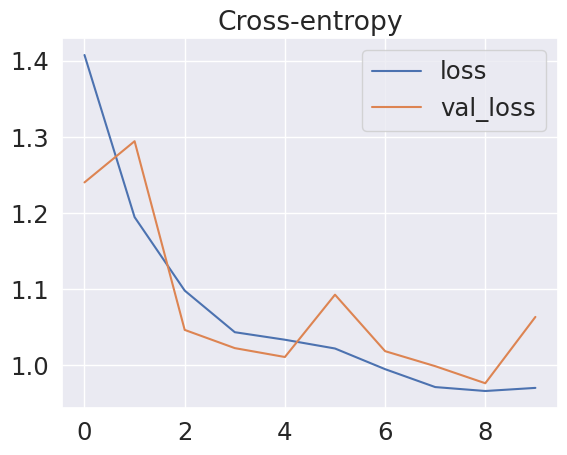

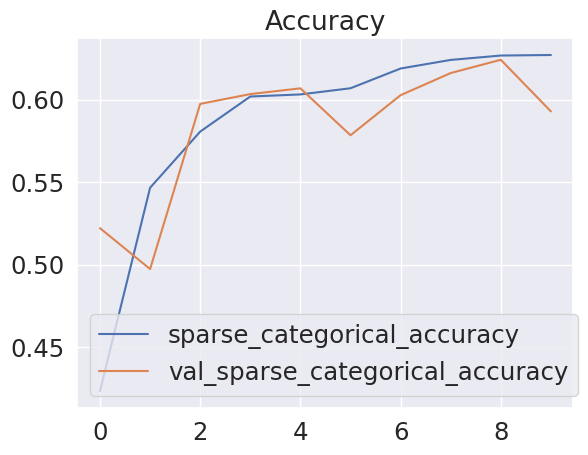

In [25]:
# Plot learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(title="Accuracy")

print('Final accuracy on validation set:', history_df.loc[len(history_df)-1,'val_sparse_categorical_accuracy'])

**Evaluate on test set**

In [26]:
# Make predictions on test set
preds = model.predict(X_test_pad)

# Retrieve most likely class
class_preds = np.argmax(preds,axis=1)

# Print accuracy
print(f"Test set accuracy: {accuracy_score(y_test, class_preds):.4f}")

385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test set accuracy: 0.5975


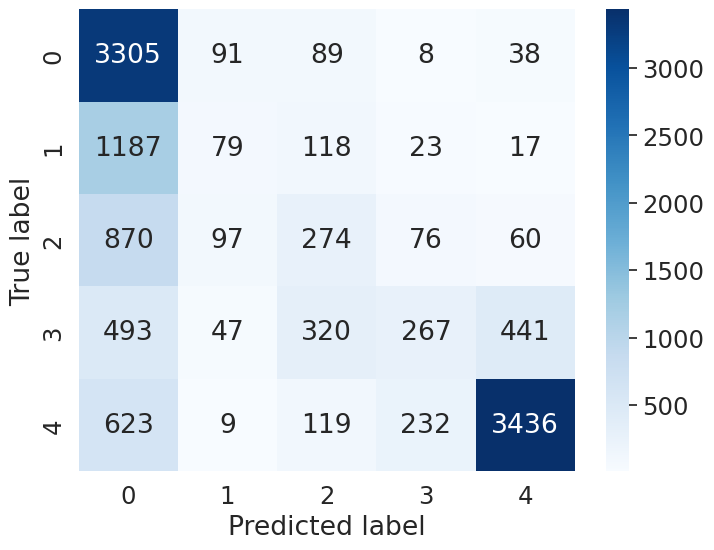

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, class_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">Modelling with word embeddings from scratch</p>

Sometimes we might not want to use pretrained word embeddings and instead let our model figure out the **best word representations for our task** at hand. By default, the keras embedding layer does this **automatically**. 

In [28]:
# Embedding layer to train from scratch
embedding_layer = layers.Embedding(
    input_dim = num_tokens,
    output_dim = embedding_dim,
    input_length = max_length
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Train Model**

In [29]:
# Build and train model
model_sc = build_model(embedding_layer)
history_sc = model_sc.fit(
    X_train_pad, y_train,
    validation_data=(X_valid_pad, y_valid),
    epochs=10,
    batch_size=128,
    verbose=True
)

Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - loss: 1.4764 - sparse_categorical_accuracy: 0.3640 - val_loss: 1.2848 - val_sparse_categorical_accuracy: 0.5123
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - loss: 1.2565 - sparse_categorical_accuracy: 0.5218 - val_loss: 1.1896 - val_sparse_categorical_accuracy: 0.5561
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - loss: 1.1237 - sparse_categorical_accuracy: 0.5717 - val_loss: 1.0742 - val_sparse_categorical_accuracy: 0.5881
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - loss: 1.0618 - sparse_categorical_accuracy: 0.5934 - val_loss: 1.1002 - val_sparse_categorical_accuracy: 0.5784
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - loss: 1.0264 - sparse_categorical_accuracy: 0.6061 - val_loss: 1.0719 - val_sparse_categorical_accuracy: 0.5877
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - loss: 1.0107 - sparse_categorical_accuracy: 0.6175 - val_loss: 0.9869 - val_sparse_categorical_accuracy:

**Learning curves**

Final accuracy on validation set: 0.6210731267929077


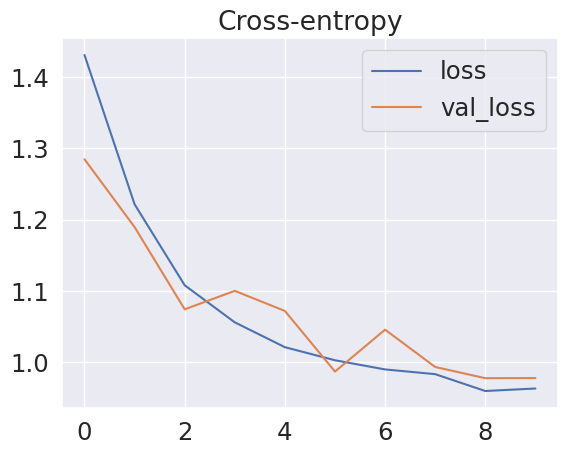

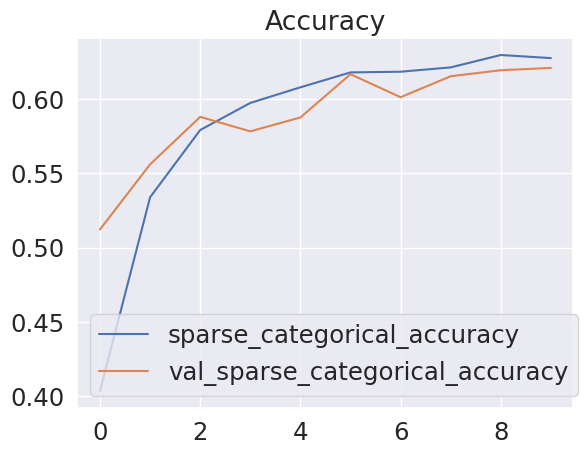

In [30]:
# Plot learning curves
history_sc_df = pd.DataFrame(history_sc.history)
history_sc_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_sc_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(title="Accuracy")

print('Final accuracy on validation set:', history_sc_df.loc[len(history_sc_df)-1,'val_sparse_categorical_accuracy'])

**Evaluate on test set**

In [31]:
# Make predictions on test set
preds_sc = model_sc.predict(X_test_pad)

# Retrieve most likely class
class_preds_sc = np.argmax(preds_sc,axis=1)

# Print accuracy
print(f"Test set accuracy: {accuracy_score(y_test, class_preds_sc):.4f}")

385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test set accuracy: 0.6252


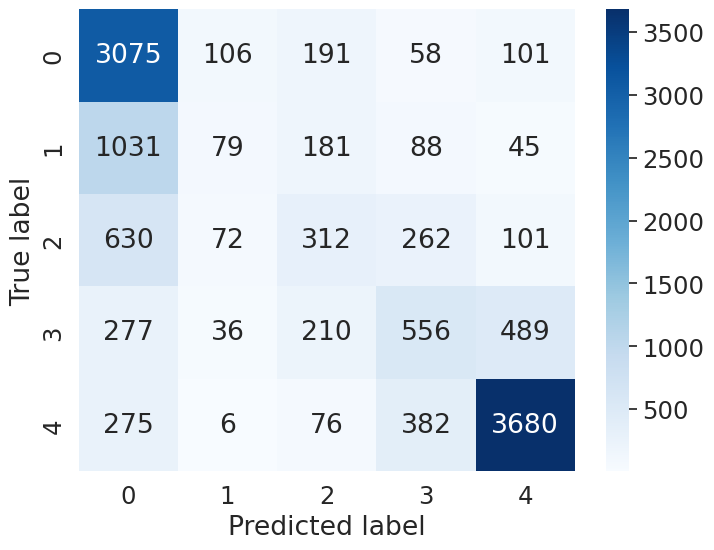

In [32]:
# Confusion matrix
cm_sc = confusion_matrix(y_test, class_preds_sc)
plt.figure(figsize=(8,6))
sns.heatmap(cm_sc, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()